### What types of issues (bugs, feature requests, theoretical questions, etc.) do developers most commonly present to ChatGPT?


In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import ast
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud
from deep_translator import GoogleTranslator
import re

/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv('./RQ2_en_clean.csv')

#### Prompt

In [11]:
# extract prompt data from the DataFrame
prompt_list = list(df['Prompt'])

# clean the prompt data by removing newline characters
cleaned_prompts = [str(prompt).replace('\n', '').replace('\r', '') for prompt in prompt_list]

# load the small English model from SpaCy
nlp_model = spacy.load("en_core_web_sm")
excluded_pipes = ["ner", "parser"]

# define a custom tokenizer function
def tokenize_with_lemmas(document):
    with nlp_model.disable_pipes(*excluded_pipes):
        return [token.lemma_ for token in document if token.is_alpha and not token.is_space and not token.is_punct and not token.is_stop and token.pos_ in ["ADJ", "NOUN", "VERB"]]

# tokenize the cleaned prompt data
tokenized_prompts = list(map(tokenize_with_lemmas, nlp_model.pipe(cleaned_prompts, batch_size=32, n_process=6)))

# create a dictionary object from the tokenized data
prompt_dictionary = corpora.Dictionary(tokenized_prompts)

# filter the dictionary to keep words that appear at least 3 times and have a frequency greater than 0.5
prompt_dictionary.filter_extremes(no_below=3, no_above=0.5)
print('Filtered prompt vocabulary size:', len(prompt_dictionary))

# convert the tokenized text data into bag-of-words model format
bag_of_words = [prompt_dictionary.doc2bow(tokens) for tokens in tokenized_prompts]


/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' mod

Filtered prompt vocabulary size: 1592


In [13]:
# build an LDA model using the bag-of-words representation, specifying 10 topics and 10 iterations
lda_model1 = models.LdaModel(corpus=bag_of_words, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=prompt_dictionary, random_state=30)
# print the topics generated by the LDA model
lda_model1.print_topics()

[(0,
  '0.069*"line" + 0.051*"module" + 0.033*"file" + 0.027*"import" + 0.023*"kwargs" + 0.018*"args" + 0.014*"return" + 0.013*"hodor" + 0.011*"linux" + 0.011*"version"'),
 (1,
  '0.017*"src" + 0.016*"language" + 0.012*"range" + 0.012*"set" + 0.012*"student" + 0.011*"public" + 0.010*"model" + 0.010*"test" + 0.009*"include" + 0.009*"format"'),
 (2,
  '0.048*"def" + 0.040*"usage" + 0.035*"span" + 0.034*"return" + 0.031*"null" + 0.027*"response" + 0.023*"item" + 0.017*"device" + 0.017*"false" + 0.017*"yield"'),
 (3,
  '0.028*"loss" + 0.028*"issue" + 0.027*"return" + 0.025*"def" + 0.024*"logit" + 0.023*"const" + 0.022*"label" + 0.017*"output" + 0.014*"token" + 0.013*"class"'),
 (4,
  '0.098*"lib" + 0.080*"line" + 0.070*"package" + 0.047*"local" + 0.036*"site" + 0.027*"dist" + 0.024*"pm" + 0.022*"return" + 0.020*"file" + 0.020*"transformer"'),
 (5,
  '0.026*"model" + 0.017*"rensantheworld" + 0.016*"task" + 0.015*"schedule" + 0.014*"scheduling" + 0.014*"program" + 0.012*"operator" + 0.012*"o

In [15]:
# calculate the proportion of each topic across all prompts
topic_distributions = list(lda_model1.get_document_topics(bag_of_words, minimum_probability=0))
# iterate through each topic to calculate and display its proportion
for topic_index in range(10):
    topic_percentage = 100 * sum(pair[topic_index][1] for pair in topic_distributions) / len(topic_distributions)
    print('Topic {}: {:.1f}%'.format(topic_index, topic_percentage))

Topic 0: 11.8%
Topic 1: 10.7%
Topic 2: 5.9%
Topic 3: 7.0%
Topic 4: 5.6%
Topic 5: 8.5%
Topic 6: 10.3%
Topic 7: 16.5%
Topic 8: 13.2%
Topic 9: 10.5%


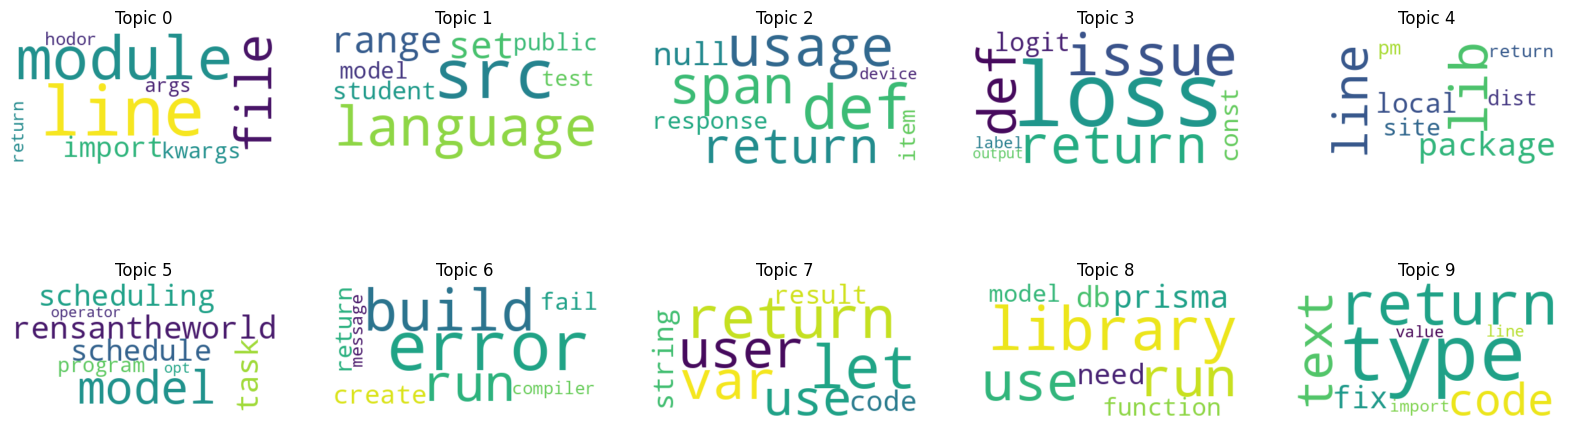

In [16]:
# plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=8)
fig, axes = plt.subplots(2, 5, figsize=(20, 6))

# generate and display word clouds for each topic
for index, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model1.show_topic(index))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {index}')
    plt.gca().axis('off')
# show the plot
plt.show()

#### Answer

In [17]:
# extract answer data from the DataFrame
answer_list = list(df['Answer'])
# clean the answer data by removing newline characters
cleaned_answers = [str(answer).replace('\n', '').replace('\r', '') for answer in answer_list]

# load the small English model from SpaCy
nlp_model = spacy.load("en_core_web_sm")
excluded_pipes = ["ner", "parser"]

# define a custom tokenizer function
def tokenize_with_lemmas(document):
    with nlp_model.disable_pipes(*excluded_pipes):
        return [token.lemma_ for token in document if token.is_alpha and not token.is_space and not token.is_punct and not token.is_stop and token.pos_ in ["ADJ", "NOUN", "VERB"]]

# tokenize the cleaned answer data
tokenized_answers = list(map(tokenize_with_lemmas, nlp_model.pipe(cleaned_answers, batch_size=32, n_process=6)))

# create a dictionary object from the tokenized data
answer_dictionary = corpora.Dictionary(tokenized_answers)

# filter the dictionary to keep words that appear at least 3 times and have a frequency greater than 0.5
answer_dictionary.filter_extremes(no_below=3, no_above=0.5)
print('Filtered answer vocabulary size:', len(answer_dictionary))

# convert the tokenized text data into bag-of-words model format
bag_of_words = [answer_dictionary.doc2bow(tokens) for tokens in tokenized_answers]


/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' mod

Filtered answer vocabulary size: 2883


In [18]:
# build an LDA model using the bag-of-words representation, specifying 10 topics and 10 iterations
lda_model2 = models.LdaModel(corpus=bag_of_words, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=answer_dictionary, random_state=30)
# print the topics generated by the LDA model
lda_model2.print_topics()

[(0,
  '0.020*"user" + 0.017*"datum" + 0.016*"message" + 0.012*"request" + 0.012*"use" + 0.011*"server" + 0.011*"need" + 0.011*"token" + 0.010*"send" + 0.010*"stream"'),
 (1,
  '0.022*"file" + 0.016*"package" + 0.014*"code" + 0.014*"run" + 0.014*"use" + 0.014*"create" + 0.012*"step" + 0.012*"need" + 0.012*"project" + 0.009*"example"'),
 (2,
  '0.023*"code" + 0.017*"script" + 0.015*"option" + 0.014*"step" + 0.011*"run" + 0.011*"add" + 0.011*"generate" + 0.010*"need" + 0.010*"prompt" + 0.009*"file"'),
 (3,
  '0.039*"library" + 0.034*"file" + 0.013*"path" + 0.012*"system" + 0.012*"version" + 0.011*"load" + 0.011*"directory" + 0.009*"issue" + 0.009*"use" + 0.009*"need"'),
 (4,
  '0.017*"search" + 0.015*"phrase" + 0.014*"document" + 0.014*"source" + 0.013*"model" + 0.011*"result" + 0.011*"d" + 0.011*"unique" + 0.010*"identify" + 0.010*"stream"'),
 (5,
  '0.027*"model" + 0.020*"database" + 0.014*"method" + 0.011*"service" + 0.010*"application" + 0.010*"folder" + 0.009*"datum" + 0.009*"tag" +

In [19]:
# calculate the proportion of each topic across all prompts
topic_distributions = list(lda_model2.get_document_topics(bag_of_words, minimum_probability=0))
# iterate through each topic to calculate and display its proportion
for topic_index in range(10):
    topic_percentage = 100 * sum(pair[topic_index][1] for pair in topic_distributions) / len(topic_distributions)
    print('Topic {}: {:.1f}%'.format(topic_index, topic_percentage))

Topic 0: 12.6%
Topic 1: 20.0%
Topic 2: 10.6%
Topic 3: 9.7%
Topic 4: 7.9%
Topic 5: 7.8%
Topic 6: 7.6%
Topic 7: 10.1%
Topic 8: 4.6%
Topic 9: 9.1%


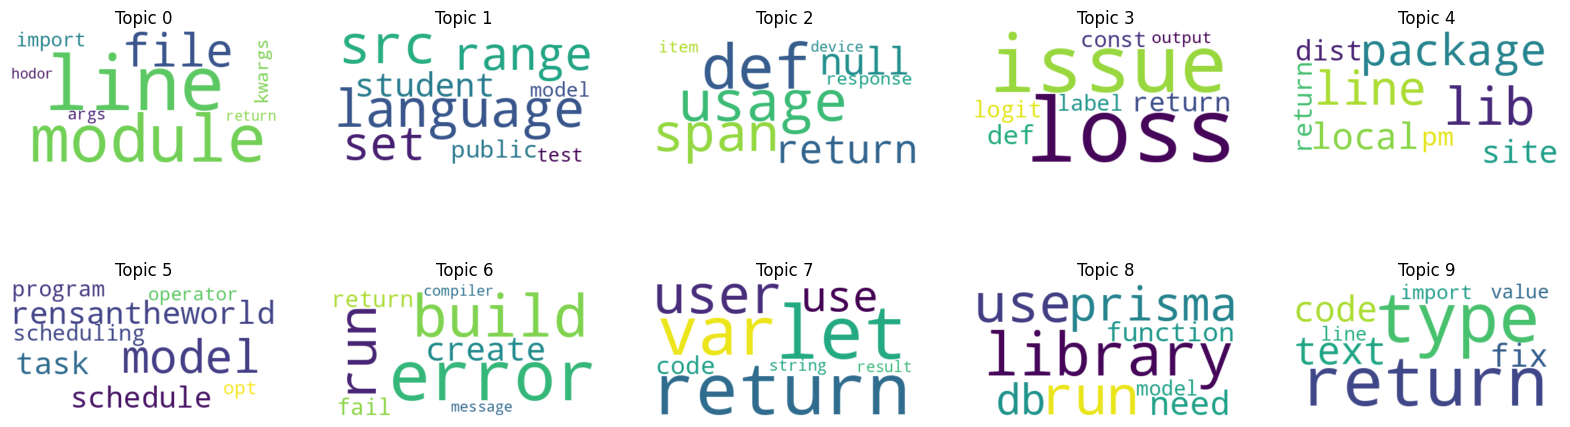

In [20]:
# plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=8)
fig, axes = plt.subplots(2, 5, figsize=(20, 6))

# generate and display word clouds for each topic
for index, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model1.show_topic(index))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {index}')
    plt.gca().axis('off')
# show the plot
plt.show()